# Data Analysis
## A Bayesian Tutorial
### Second edition (ISBN 978-0-19-856831-5)
### By D. S. Sivia, with J. Skilling
Implementation and testing of ideas from the book

<img align="left" src="images/book_cover.jpeg" width="250" />

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, norm
import math
import torch
import scipy

import random 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.nn import PyroModule
from pyro import param
from pyro.poutine import trace
from pyro import condition
from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC, NUTS
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoContinuous, AutoGuide

from torch import tensor
from torch import nn

from pprint import pprint


from tqdm import tqdm

from os.path import join, exists, basename

# for CI testing
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

display('pyro version: {}'.format(pyro.__version__))

pyro.set_rng_seed(101)

/home/martin/mambaforge/envs/pyro/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'pyro version: 1.4.0'

# 2 Parameter estimation I

## 2.1 Example 1: is this a fair coin?
A coin is flipped repeatedly, task is to figure out whether the coin is fair or not. Page 14. A central question is what prior to put. Do I have reason to expect that the coin is not fair? Do I have strong reasons to expect that it is a "normal" coin which is fair? Or would I rather not assume anything?

#### Define function that describes the coin

In [2]:
def coinflip(headfreq=0.25):
    '''
    Simulates a biased coin.
    headfreq defines the proportion of heads 
    (1 signifies head, 0 signifies tail)
    '''
    return pyro.sample('flip', dist.Bernoulli(headfreq)).item()
    

#### Generate data

In [3]:
# the first four flips are H, H, T, T, as in the book
flip_data = [1.0, 1.0, 0.0, 0.0]
translate_dict = {1.0:'H', 0.0:'T'}

# the rest is random as per the coin
num_flips = 4096 - len(flip_data)
flip_data += [coinflip() for i in range(num_flips)]
print('Proportion of heads is {:.2f} out of {} flips'.format(flip_data.count(1.0)/num_flips, len(flip_data)))

# convert to tensor
flip_data = tensor(flip_data)

Proportion of heads is 0.25 out of 4096 flips


#### Define the model

In [4]:
def model_uniform_prior(data):
    '''
    Coin flip model assuming no prior knowledge.
    I.e. coin might be fair, or completely biased.
    '''    
    # set up the prior as a beta distribution
    alpha0 = 1.0
    beta0 = 1.0
    prior = dist.Beta(alpha0, beta0) # dist.Uniform(0.0, 1.0)
    
    # now sample a head/tail probability (fairness) from this distribution
    f = pyro.sample('latent_fairness', prior)
    
    # For each of the observations, let's draw a sample from our distribution.
    with pyro.plate('observed_data'):
        pyro.sample('obs', dist.Bernoulli(f), obs=data)
    
    

#### Run the model

In [5]:
%%time


def run_model(model, num_flips, num_samples=1000):
    results = []
    for flips in num_flips:

        # Clear named parameters so that runs don't interfere
        pyro.clear_param_store()

        # Using NUTS here as it seems to perform better than HMC
        my_kernel = NUTS(model)

        # 5000 seems to strike a good balance between computation time and accuracy
        my_mcmc = MCMC(my_kernel,
                       num_samples=num_samples,
                       warmup_steps=100)

        # Only use the first datapoints, as specified by flips
        # to show how belief is updated as we see more and more data
        my_mcmc.run(flip_data[:flips])

        # store results for later plotting
        results.append(my_mcmc.get_samples()['latent_fairness'].numpy())
        
    return results

    
    
# number of flips to evaluate
num_flips = [0, 1, 2, 
            3, 4, 8,
            16, 32, 64,
            128, 256, 512,
            1024, 2048, 4096]

results_uniform_prior = run_model(model=model_uniform_prior, num_flips=num_flips)

Sample: 100%|██████████| 1100/1100 [00:02, 444.21it/s, step size=1.43e+00, acc. prob=0.875]

CPU times: user 41.5 s, sys: 122 ms, total: 41.7 s
Wall time: 44.5 s


**Make a plot of the posterior probability (similar to figure 2.1 in the book)**

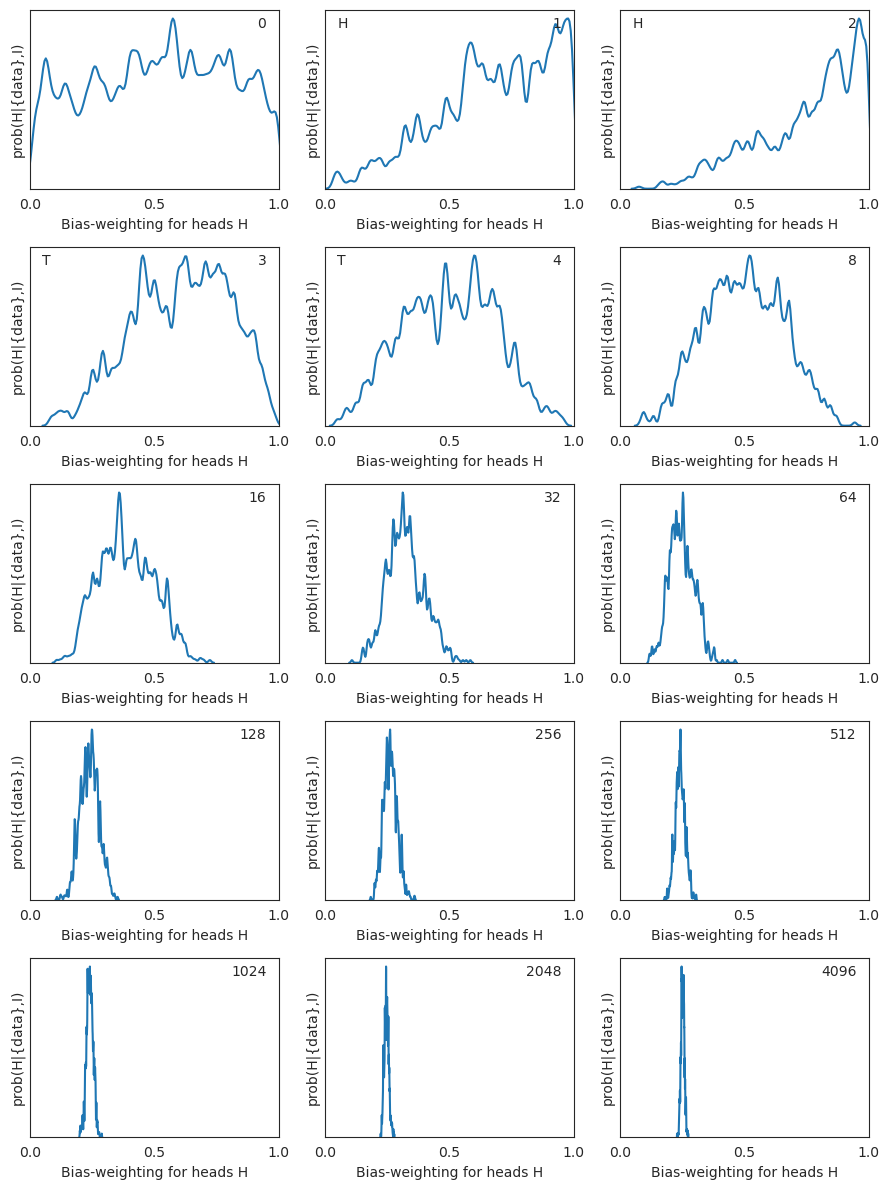

In [6]:
fig = plt.figure(figsize=(9, 12))

sns.set_style('white')
for i in range(0, 15):

    ax = fig.add_subplot(5, 3, i+1)

    sns.kdeplot(np.array(results_uniform_prior[i]), bw_method=0.05)

    plt.xlim((0.0, 1.0))
    plt.xticks(np.arange(0, 1.1, step=0.5))
    plt.xlabel("Bias-weighting for heads H")

    plt.yticks([])
    plt.ylabel("prob(H|{data},I)")

    # indicate number of flips
    plt.text(0.95, 0.9, '{}'.format(num_flips[i]), 
             horizontalalignment='right',
            transform=ax.transAxes)
    
    # write out whether heads or tails in the first four flips
    if i in [1, 2, 3, 4]:
        plt.text(0.05, 0.9, '{}'.format(translate_dict[int(flip_data[i-1])]), # need -1 here as the first flip_data entry is is zero flips
                 horizontalalignment='left',
                transform=ax.transAxes)
    
plt.tight_layout()
plt.show()

**Evaluate the effect of the prior (similar to figure 2.2 in the book)**

In [8]:
def model_heavy_tails(data):
    '''
    Coin flip model assuming that the coin
    is almost certainly completely biased
    toward 0 or 1.
    '''    
    # set up the prior as a beta distribution
    alpha0 = 0.1
    beta0 = 0.1
    prior = dist.Beta(alpha0, beta0) 
    
    # now sample a head/tail probability (fairness) from this distribution
    f = pyro.sample('latent_fairness', prior)
    
    # For each of the observations, let's draw a sample from our distribution.
    with pyro.plate('observed_data'):
        pyro.sample('obs', dist.Bernoulli(f), obs=data)
        
        
def model_heavy_center(data):
    '''
    Coin flip model assuming that the coin
    is almost certainly fair.
    '''    
    # set up the prior as a mnormal distribution
    alpha0 = 100
    beta0 = 100
    prior = dist.Beta(alpha0, beta0) 
    
    # now sample a head/tail probability (fairness) from this distribution
    f = pyro.sample('latent_fairness', prior)
    
    # For each of the observations, let's draw a sample from our distribution.
    with pyro.plate('observed_data'):
        pyro.sample('obs', dist.Bernoulli(f), obs=data)
        

# carry out coinflips for the biased models
results_tails_prior = run_model(model=model_heavy_tails, num_flips=num_flips)
results_center_prior = run_model(model=model_heavy_center, num_flips=num_flips)

Sample: 100%|██████████| 1100/1100 [00:03, 313.38it/s, step size=7.71e-01, acc. prob=0.960]


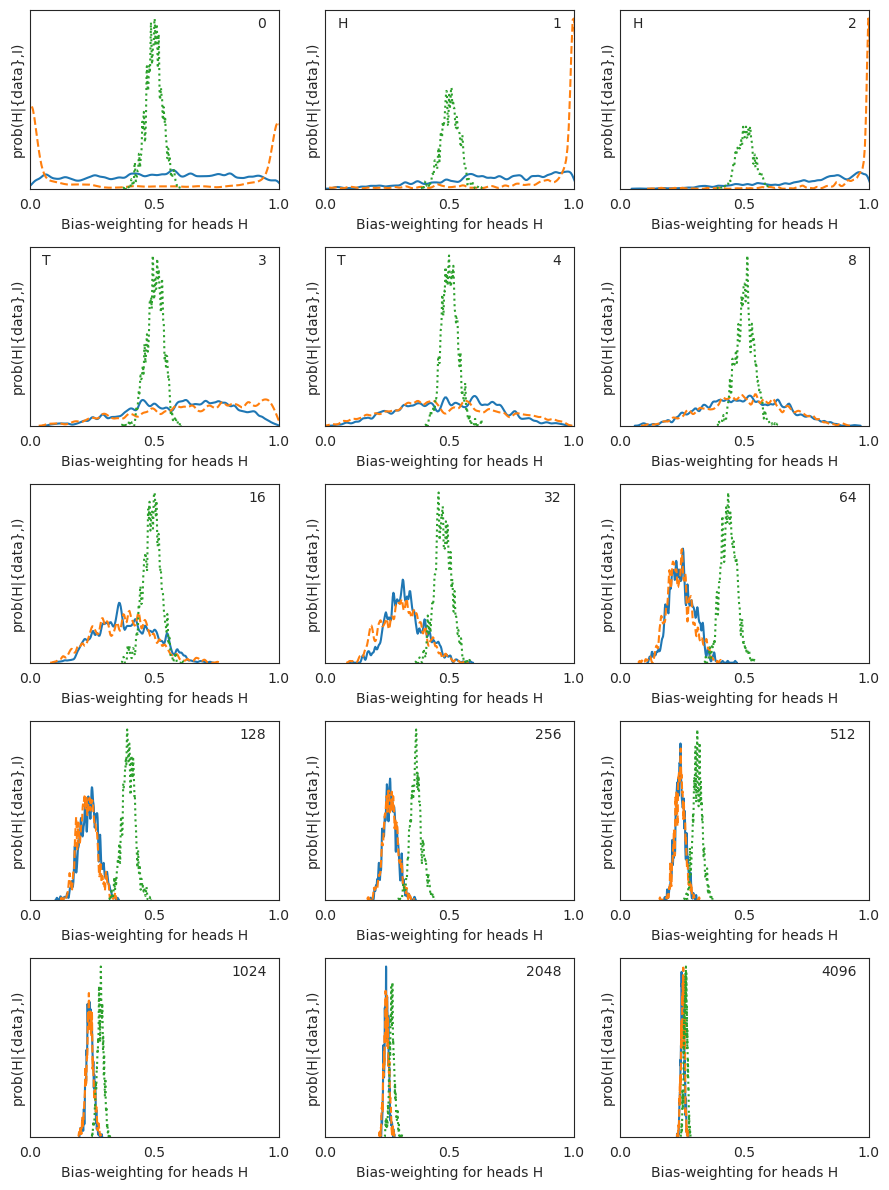

In [9]:
fig = plt.figure(figsize=(9, 12))

sns.set_style('white')
for i in range(0, 15):

    ax = fig.add_subplot(5, 3, i+1)

    sns.kdeplot(np.array(results_uniform_prior[i]), bw_method=0.05, linestyle='-')
    sns.kdeplot(np.array(results_tails_prior[i]), bw_method=0.05, linestyle='--')
    sns.kdeplot(np.array(results_center_prior[i]), bw_method=0.05, linestyle=':')
    
#     plt.hist(results_tails_prior[i], bins=50, range=[0.0, 1.0], 
#          histtype='stepfilled', alpha=0.3, color='steelblue', edgecolor='none')

    plt.xlim((0.0, 1.0))
    plt.xticks(np.arange(0, 1.1, step=0.5))
    plt.xlabel("Bias-weighting for heads H")

    plt.yticks([])
    plt.ylabel("prob(H|{data},I)")

    # indicate number of flips
    plt.text(0.95, 0.9, '{}'.format(num_flips[i]), 
             horizontalalignment='right',
            transform=ax.transAxes)
    
    # write out whether heads or tails in the first four flips
    if i in [1, 2, 3, 4]:
        plt.text(0.05, 0.9, '{}'.format(translate_dict[int(flip_data[i-1])]), # need -1 here as the first flip_data entry is is zero flips
                 horizontalalignment='left',
                 transform=ax.transAxes)
    
plt.tight_layout()
plt.show()

#### Conclusions
For a small number of coin tosses the prior is very important. But given enough pieces of data the results converge.

### Try the same computation using SVI
The MCMC approach is nice but takes a long time to compute. Let's try another way.

In [10]:
def model_guide(data):
    '''
    '''
    # set up the prior as a beta distribution
    alpha = param('alpha', tensor(1.0), constraint=dist.constraints.positive)
    beta = param('beta', tensor(1.0), constraint=dist.constraints.positive)
    prior = dist.Beta(alpha, beta) # dist.Uniform(0.0, 1.0)
    
    # now sample a head/tail probability (fairness) from this distribution
    f = pyro.sample('latent_fairness', prior)

#### Update the model with data

"alpha" is 1.1722145080566406 after 0 flips
"beta" is 0.6921340227127075 after 0 flips
"alpha" is 2.9413106441497803 after 1 flips
"beta" is 1.6057437658309937 after 1 flips
"alpha" is 4.111161231994629 after 2 flips
"beta" is 0.9103731513023376 after 2 flips
"alpha" is 3.193250894546509 after 3 flips
"beta" is 2.578991413116455 after 3 flips
"alpha" is 4.632034778594971 after 4 flips
"beta" is 3.286639451980591 after 4 flips
"alpha" is 3.7714290618896484 after 8 flips
"beta" is 4.170261859893799 after 8 flips
"alpha" is 6.498076438903809 after 16 flips
"beta" is 12.01478385925293 after 16 flips
"alpha" is 13.841888427734375 after 32 flips
"beta" is 23.329090118408203 after 32 flips
"alpha" is 17.735877990722656 after 64 flips
"beta" is 50.03884506225586 after 64 flips
"alpha" is 27.9908504486084 after 128 flips
"beta" is 114.91334533691406 after 128 flips
"alpha" is 71.96200561523438 after 256 flips
"beta" is 193.07232666015625 after 256 flips
"alpha" is 119.00383758544922 after 512 f

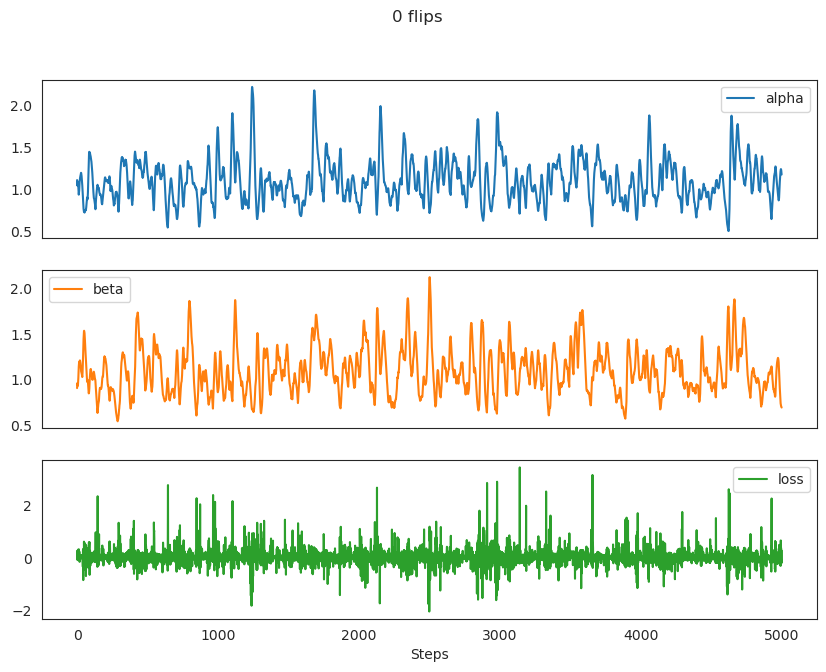

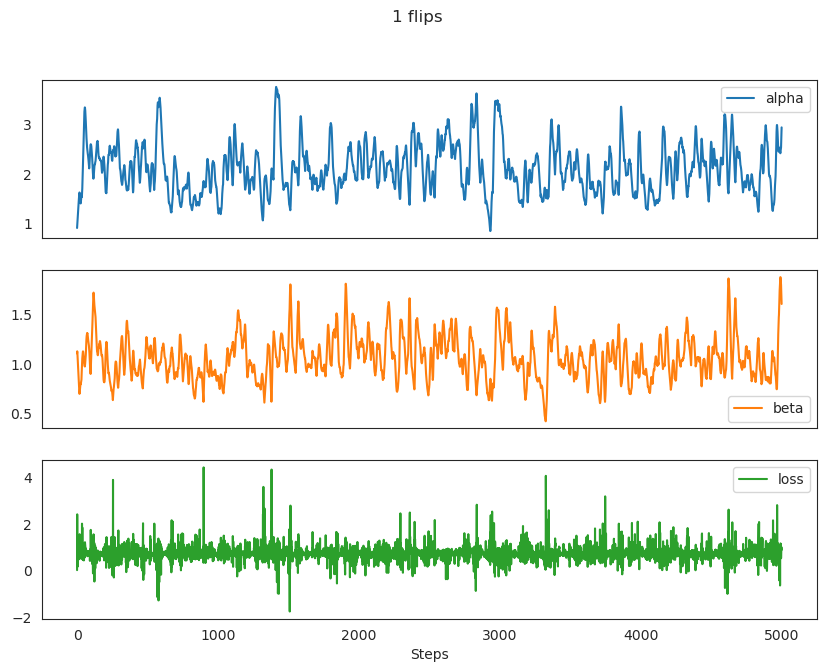

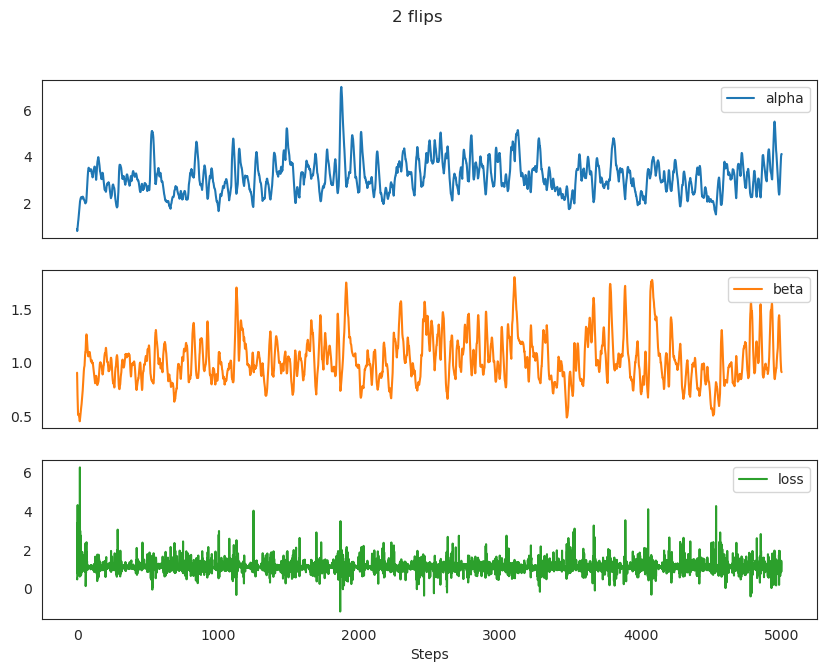

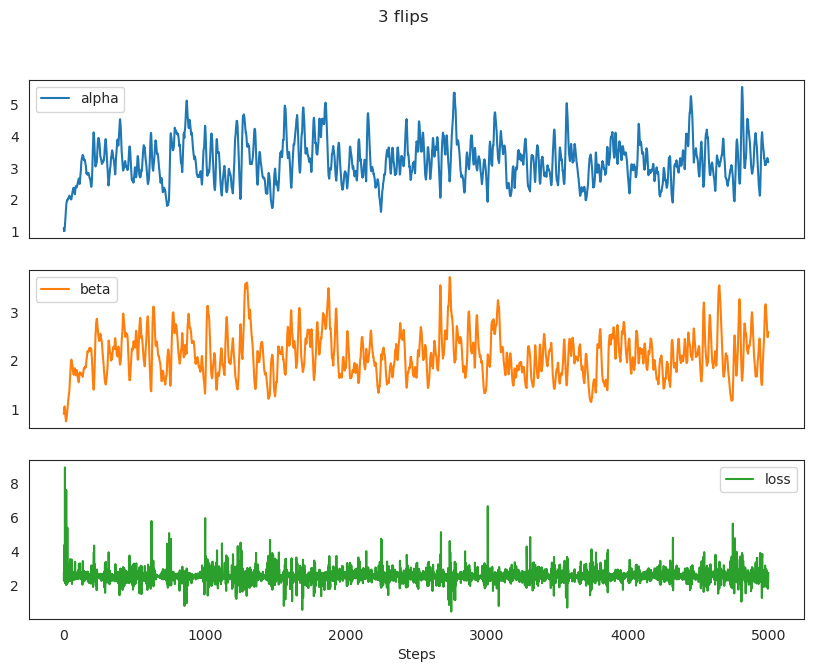

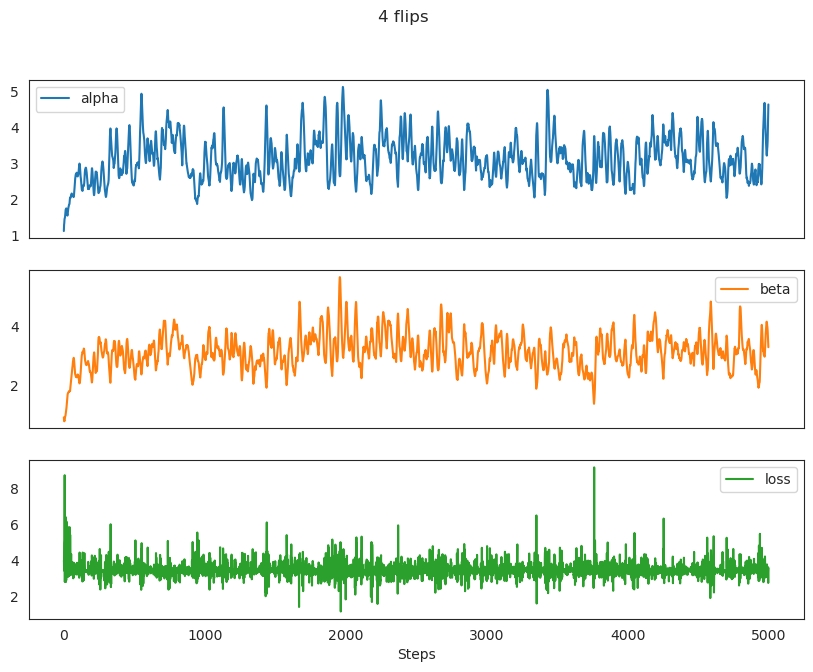

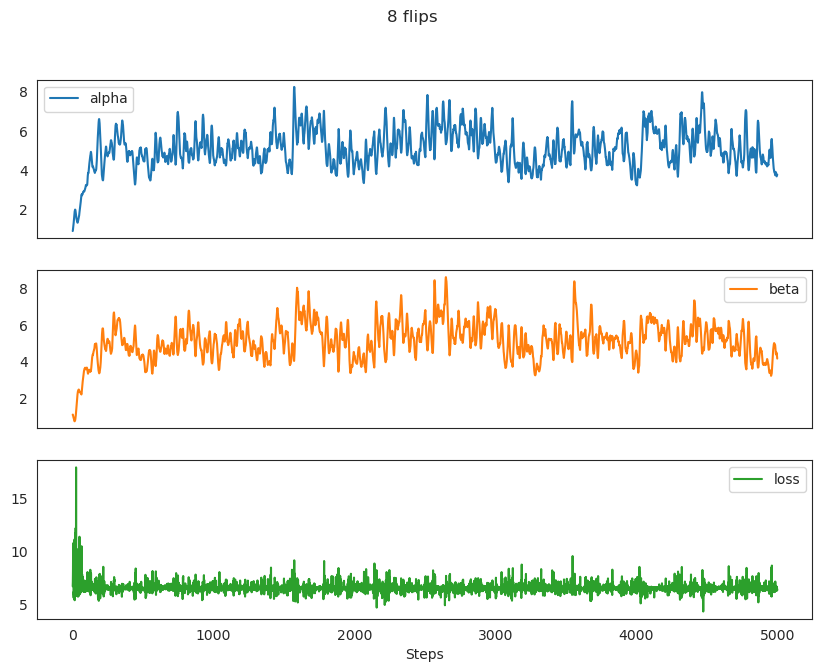

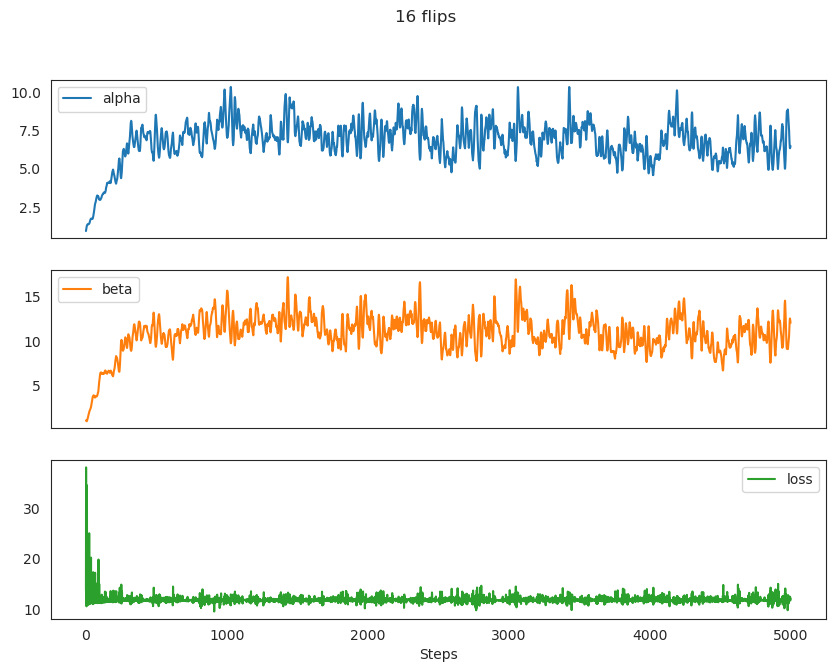

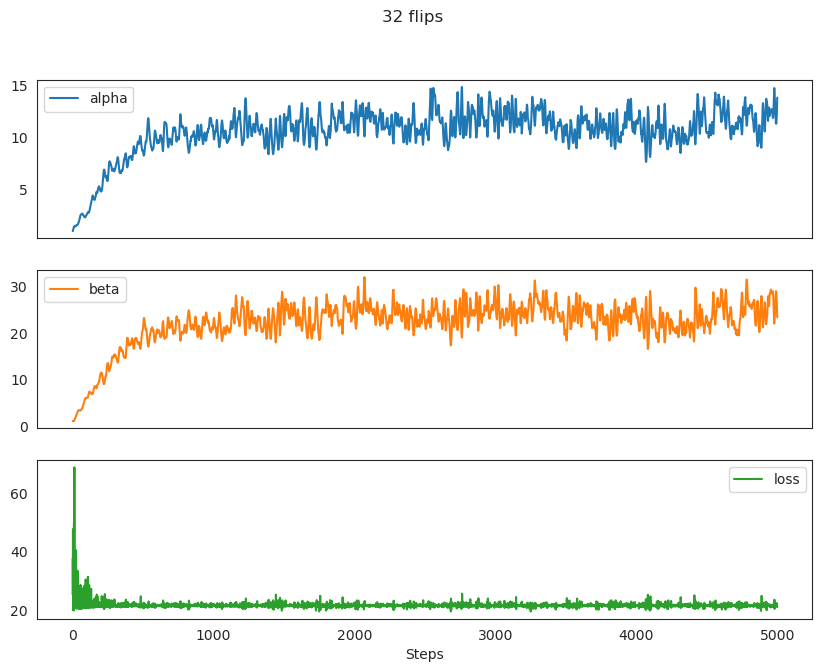

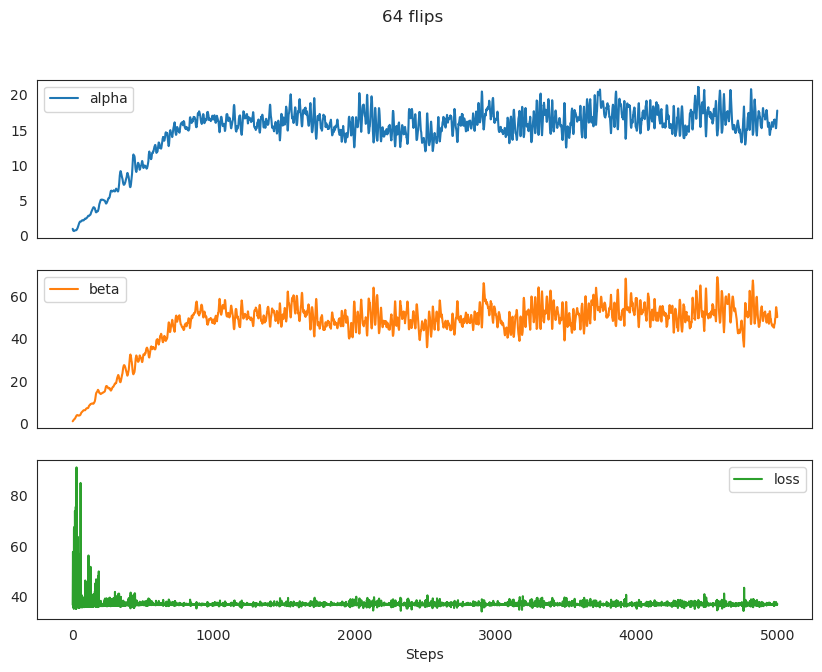

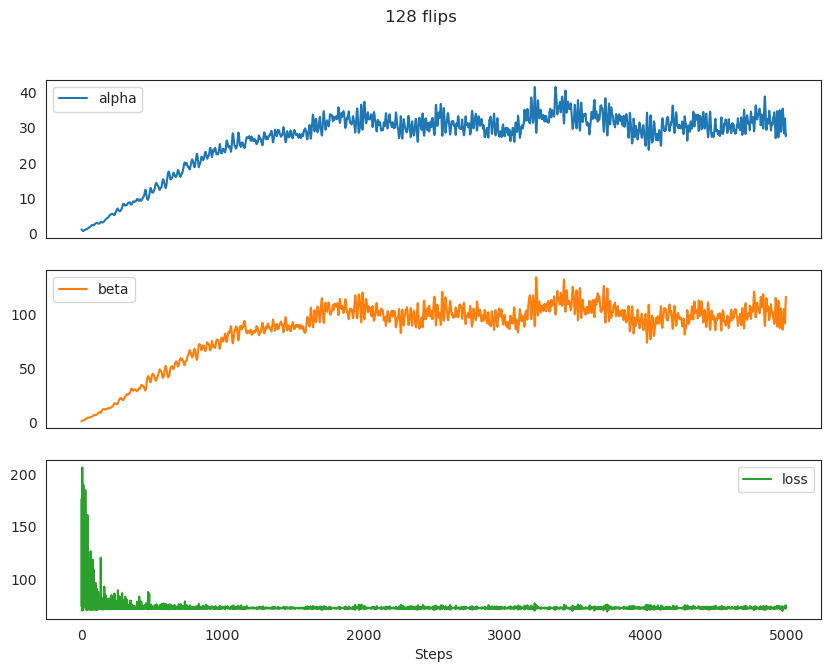

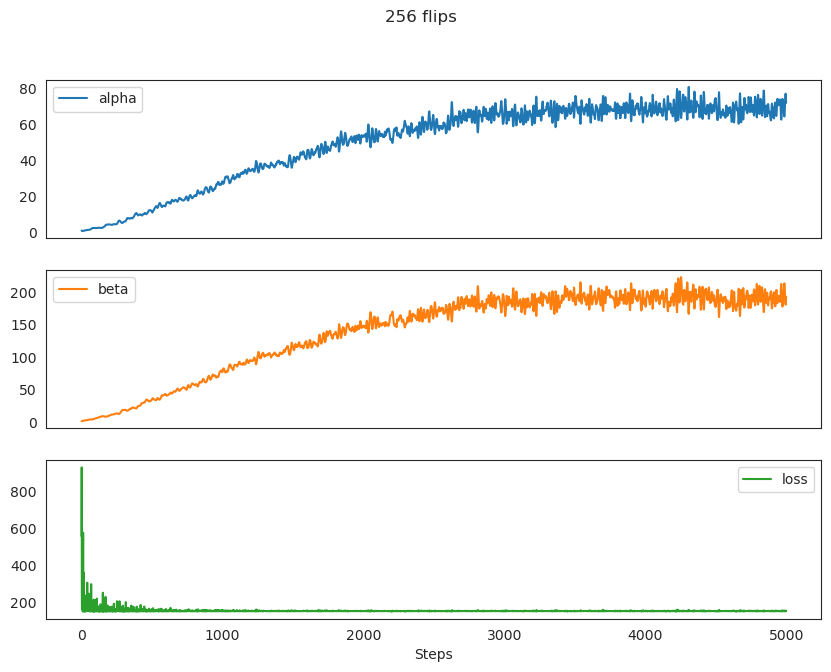

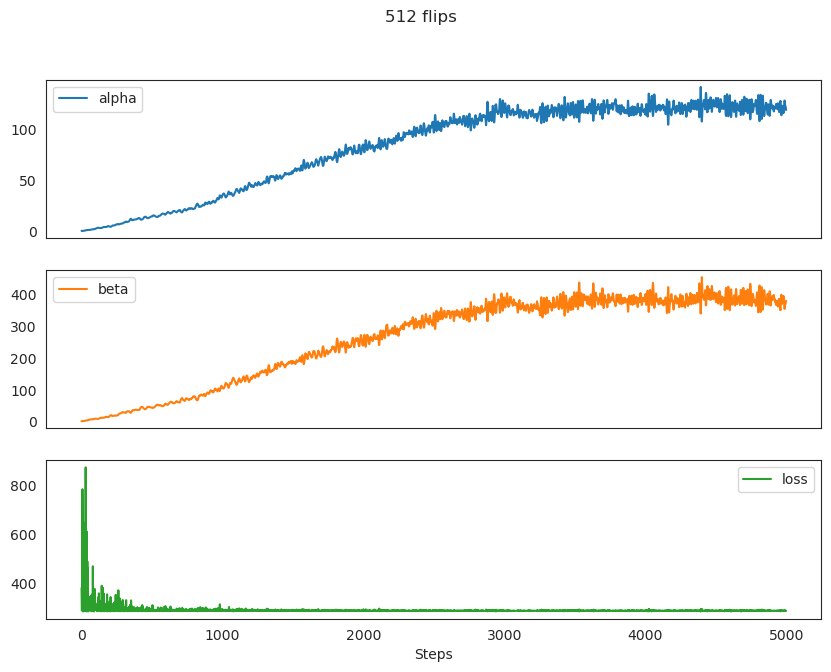

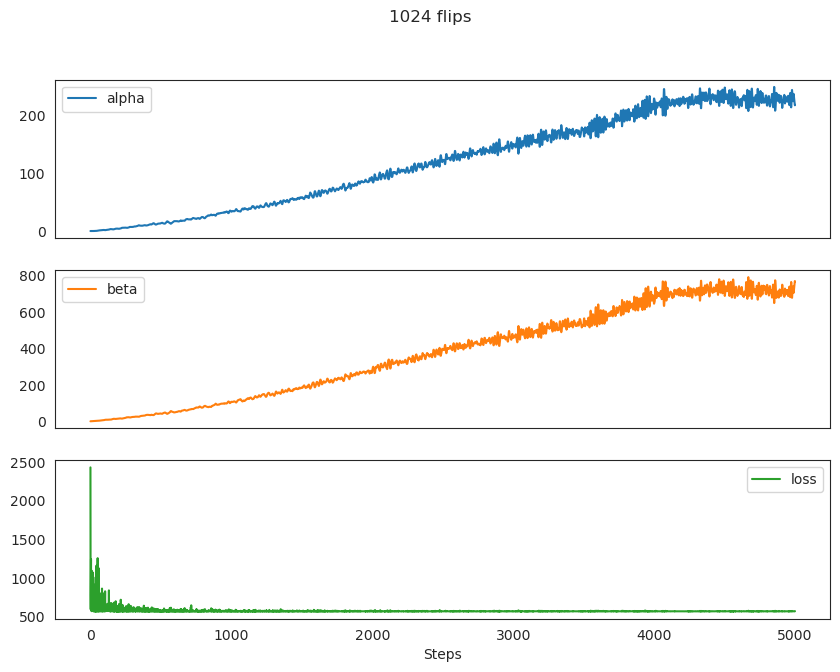

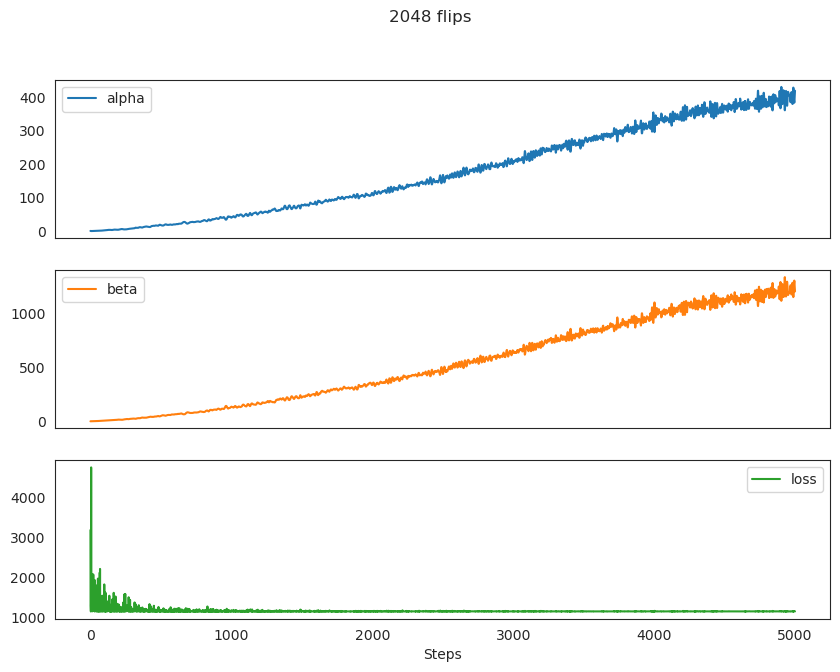

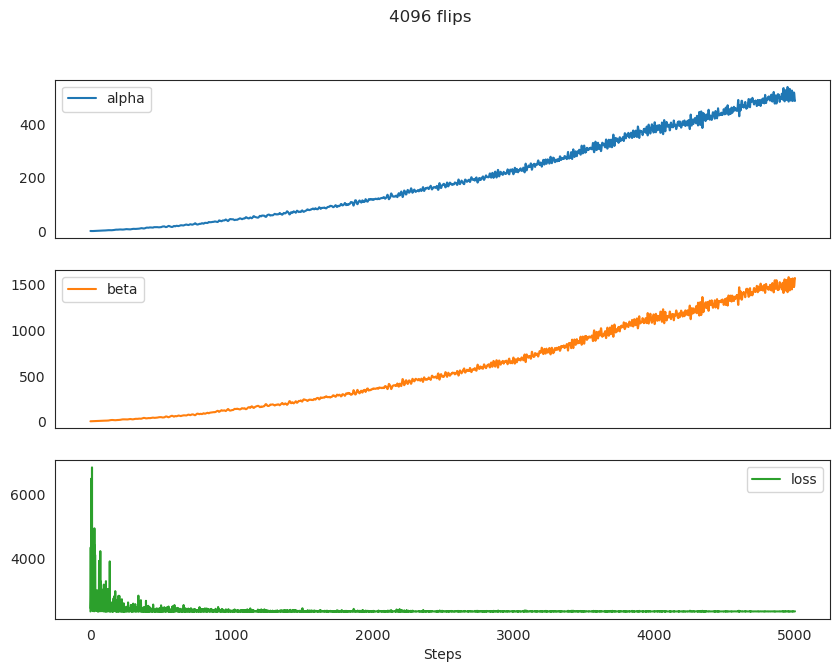

In [11]:
%%time


# Run optimization
results = []

for flips in num_flips:
    
    # Clear all the parameter store
    pyro.clear_param_store()

    # Define the SVI algorithm.
    my_svi = SVI(model=model_uniform_prior,
                 guide=model_guide,
                 optim=Adam({"lr": 0.1}),
                 loss=Trace_ELBO())
    
    param_vals = []
    optimization_steps = 5000
    for i in range(optimization_steps):

        loss = my_svi.step(flip_data[:flips])

        # store values for inspection later
        param_vals.append({k: param(k).item() for k in ['alpha', 'beta']})
        param_vals[-1]['loss'] = loss

        if (i % 100 == 0):
            print(f'iter: {i}, loss: {round(loss, 2)}', end="\r")

    results.append(param_vals)
        
    # plot the parameters and the loss
    pd.DataFrame(param_vals).plot(subplots=True, figsize=(10,7), title='{} flips'.format(flips))
    plt.xlabel('Steps')

    print(f'"alpha" is {pyro.param("alpha")} after {flips} flips')
    print(f'"beta" is {pyro.param("beta")} after {flips} flips')

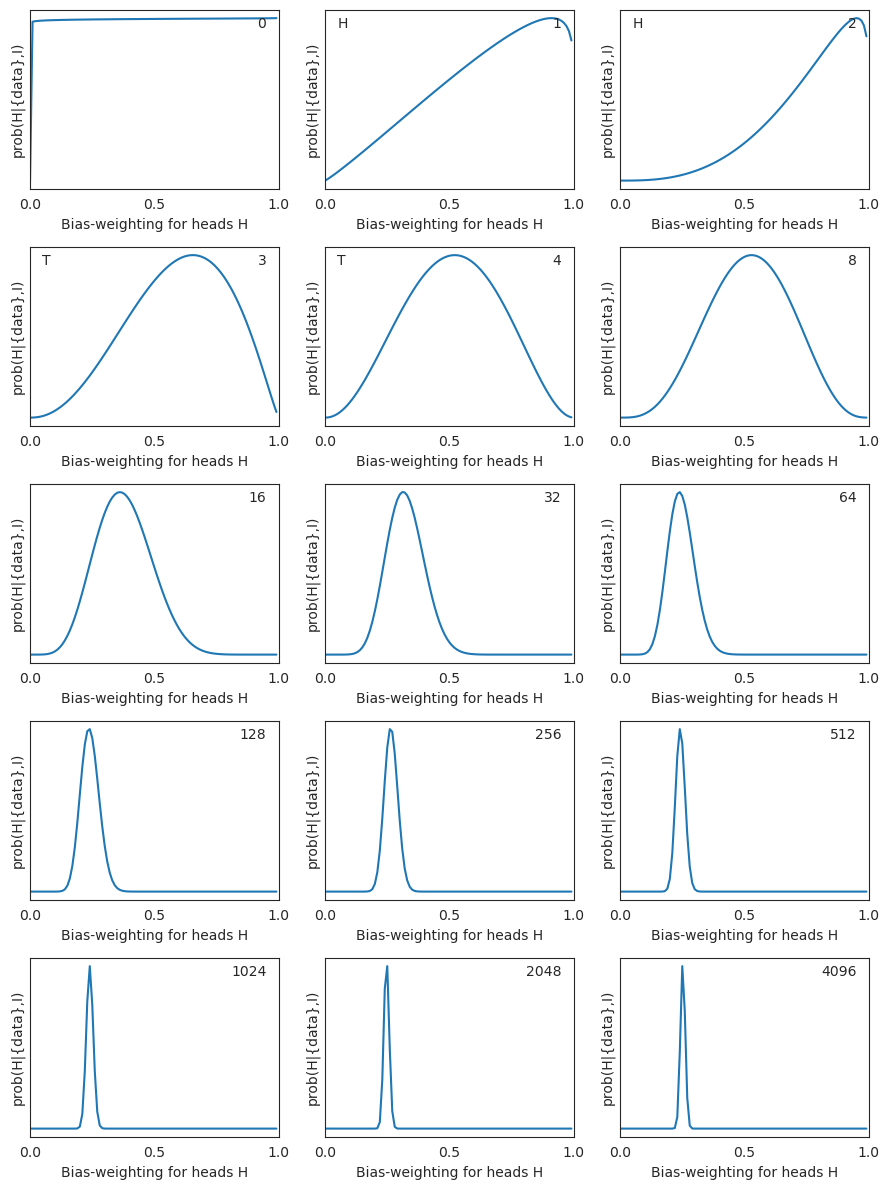

In [12]:
fig = plt.figure(figsize=(9, 12))


for i in range(0, 15):

    ax = fig.add_subplot(5, 3, i+1)

    # take the mean of the last 100 steps (because the variables bounce around)
    sum_over = 100
    a = sum([results[i][-j]['alpha'] for j in range(1, sum_over+1)]) / sum_over
    b = sum([results[i][-j]['beta'] for j in range(1, sum_over+1)]) / sum_over
    x = np.arange(0, 1.0, 0.01)
    y = beta.pdf(x, a, b, scale=1.0, loc=0.0)
    plt.plot(x, y)

    plt.xlim((0.0, 1.0))
    plt.xticks(np.arange(0, 1.1, step=0.5))
    plt.xlabel("Bias-weighting for heads H")

    plt.yticks([])
    plt.ylabel("prob(H|{data},I)")

    # indicate number of flips
    plt.text(0.95, 0.9, '{}'.format(num_flips[i]), 
             horizontalalignment='right',
            transform=ax.transAxes)
    
    # write out whether heads or tails in the first four flips
    if i in [1, 2, 3, 4]:
        plt.text(0.05, 0.9, '{}'.format(translate_dict[int(flip_data[i-1])]), # need -1 here as the first flip_data entry is is zero flips
                 horizontalalignment='left',
                transform=ax.transAxes)
    
plt.tight_layout()
plt.show()


#### Conclusion:
Works faster when sampling a large number of tosses. But on the other hand I think it only works for well-behaved distributions, i.e. not work for multimodal ones. It's also hard to tell progress from loss measure.

## 2.4 Example 3: the lighthouse problem (Page 29)
Following Gull 1988: "A lighthouse is somewhere off a piece of straight coastlien at a position $\alpha$ along the shore and a distance $\beta$ out at sea. It emits a series of short highly collimated flashes at random intervals and hence at rando azimuths. These pulses are intercepted on the coast by photo-detectors that record only the fact that a flash has occured, but not the angle from which it camel. *N* flashes have so far been recorded at position $\{x_k\}$. Where is the lighthouse?


To solve theis problem both $\alpha$ and $\beta$ need to be estimated, but to simplify the problem we here assume that $\beta$ is known to be 1 km. 



<img align="left" src="images/figure_2.7.png" width="550" /> <br clear="all" />

Figure 2.7, page 30.


The first eight datapoints as indicated in figure 2.9 on page 33 were extracted from the book figure using WebPlotDigitizer https://automeris.io/WebPlotDigitizer/) and saved to `./data/ex3_lighthouse.tsv`.


In contrast to the book I do tackle the two-parameter problem here, so both unknown alpha and unknown beta. I benefit greatly from the fact that it is stated in the book that the data points follow a Cauchy distribution with an FWHM of 2 beta. Had I not been provided this information I would have had to fit the data to different distributions and determine that Cauchy is appropriate in that way instead.

**Prepare the data**

[4.7, 0.4, -1.8, 0.1, 1.0, 1.1, 1.3, 2.2]

torch.Size([512])

<AxesSubplot:ylabel='Density'>

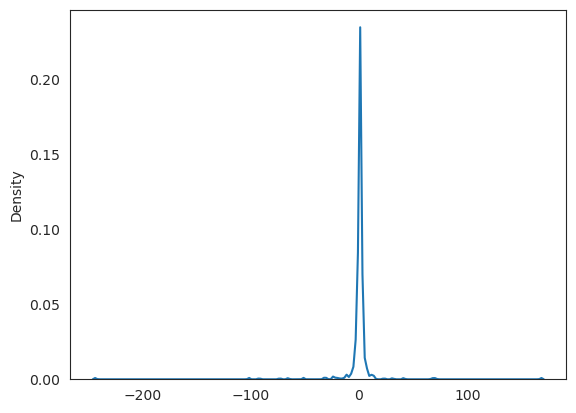

In [13]:
def lighthouse(alpha=1, beta=1):
    '''
    Simulates the lighthouse, for 
    generating data. Values for alpha
    and beta are given in the text.
    '''
    # randomly sample an angle from -90 to +90
    theta = pyro.sample('theta', dist.Uniform(-90., 90.)).item()
    return beta * math.tan(theta) + alpha


# get the first eight data points
with open('./data/ex3_lighthouse.tsv', 'r') as f:
    flash_data = list(map(float, f.readlines()))

display(flash_data)

# number of flashes to evaluate
num_flashes = [1, 2, 3, 8, 64, 512]

# the rest is random as per the lighthouse
num_data = num_flashes[-1] - len(flash_data)
flash_data.extend([lighthouse() for i in range(num_data)])

# convert to tensor
flash_data = tensor(flash_data)
display(flash_data.shape)

# plot the generated x-values
sns.kdeplot(flash_data.numpy(), bw_method=0.05)

**Create the model**

In [14]:
def lighthouse_model(data):
    '''
    A model estimating both the alpha and beta paramtes.
    '''
    # assume at most 100 km for alpha and beta
    alpha_prior = dist.Uniform(0.0, 100.0)
    beta_prior = dist.Uniform(0.0, 100.0)
    
    # sample them
    alpha = pyro.sample('alpha', alpha_prior)
    beta = pyro.sample('beta', beta_prior)
    
    with pyro.plate('observed_data'):
        pyro.sample('obs', dist.Cauchy(alpha, beta), obs=data)
    

**Now run the model with a differing number of flashes as input**

In [15]:
%%time


def run_lighthouse_model(model, num_flashes, flash_data, num_samples=500):
    results = []
    for flashes in num_flashes:

        # Clear named parameters so that runs don't interfere
        pyro.clear_param_store()

        # Using NUTS here as it seems to perform better than HMC
        my_kernel = NUTS(model)

        # 5000 seems to strike a good balance between computation time and accuracy
        my_mcmc = MCMC(my_kernel,
                       num_samples=num_samples,
                       warmup_steps=50)

        # Only use the first n datapoints
        # to show how belief is updated as we see more and more data
        my_mcmc.run(flash_data[:flashes])

        # store results for later plotting
        results.append((my_mcmc.get_samples()['alpha'].numpy(), 
                        my_mcmc.get_samples()['beta'].numpy()))
        
    return results



# run the model
results = run_lighthouse_model(model=lighthouse_model, 
                                             num_flashes=num_flashes, 
                                             flash_data=flash_data)

Sample: 100%|██████████| 550/550 [00:22, 24.52it/s, step size=8.78e-03, acc. prob=0.986]

CPU times: user 39.5 s, sys: 40 ms, total: 39.6 s
Wall time: 39.5 s


**Plot the results**

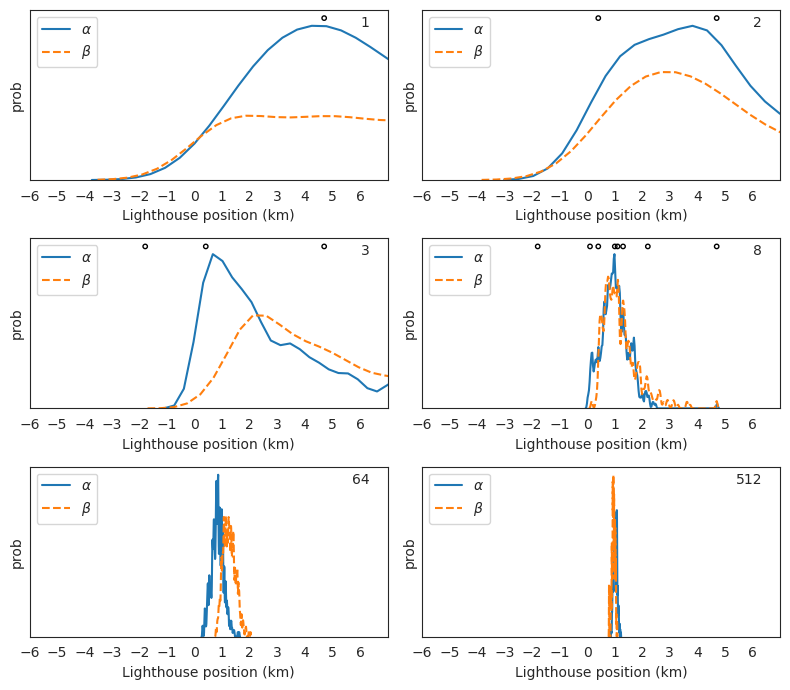

In [16]:
fig = plt.figure(figsize=(8, 7))

sns.set_style('white')
for i in range(0, 6):

    ax = fig.add_subplot(3, 2, i+1)

    p1 = sns.kdeplot(np.array(results[i][0]), 
                     bw_method=0.05, 
                     linestyle='-', 
                     label=r'$\alpha$')
    p2 = sns.kdeplot(np.array(results[i][1]), 
                     bw_method=0.05, 
                     linestyle='--',
                     label=r'$\beta$')

    plt.xlim((-6, 7))
    plt.xticks(np.arange(-6, 7, step=1.0))
    plt.xlabel(r"Lighthouse position (km)")

    plt.yticks([])
    plt.ylabel("prob")
    
    ax.legend(loc='upper left')

    # indicate number of flashes
    plt.text(0.95, 0.9, '{}'.format(num_flashes[i]), 
             horizontalalignment='right',
            transform=ax.transAxes)
    
    # indicate where the flashes were detected
    if i in [0, 1, 2, 3]:
        x = flash_data[:num_flashes[i]]
        y = [ax.get_ylim()[1] for s in x]
        plt.scatter(x, y, facecolors='none', edgecolors='black', s=10)
    
plt.tight_layout()
plt.show()

#### Conclusion:
Both alpha and beta are estmated to have the value of 1. This is also the correct value according to the book. It's a striking example of how it is possible to extract hidden variables from very simple data.

# 3 Parameter estimation II

## 3.1 Example 4: amplitude of a signal in the presence of background (page 35)
The goal is to estimate the amplitude of a signal as well as the amplitude of background noise. An experiment is imagined where data is collected in a set of fixed channels (data bins). The signal is known to follow a gaussian centered at 0 and has a FWHM of 5 units. The intuition is that measurement values obtained at the extremes will contain very little of the signal, thus being mainly noise, will allow us to estimate the level of noise. If measurements were recorded only where the signal is centered it would no longer be possible to do so. 

<img align="left" src="images/figure_3.1.png" width="550"/> <br clear="all" /><br clear="all" />
Figure 3.1, page 35.

The datapoints as from figure 3.3 on page 38 were extracted from the book figure using WebPlotDigitizer https://automeris.io/WebPlotDigitizer/) and saved to `./data/ex4_noise_plot1.tsv`, `./data/ex4_noise_plot2.tsv`, `./data/ex4_noise_plot3.tsv`, and `./data/ex4_noise_plot4.tsv`.

 Both the signal and noise can be modeled with Poisson distributions, since the data is count-based. The task then is to find the D of these distributions. For the noise the contribution is the same across all bins, but for the signal the contribution follows the gaussian.

**Prepare the data**

In [17]:
# load the data
plot1_data = pd.read_csv('./data/ex4_noise_plot1.tsv', sep='\t')
plot2_data = pd.read_csv('./data/ex4_noise_plot2.tsv', sep='\t')
plot3_data = pd.read_csv('./data/ex4_noise_plot3.tsv', sep='\t')
plot4_data = pd.read_csv('./data/ex4_noise_plot4.tsv', sep='\t')

plot1_data

,bin,value
0,-7,59
1,-6,69
2,-5,69
3,-4,77
4,-3,73
5,-2,94
6,-1,114
7,0,84
8,1,102
9,2,98


**Create the model**

In [18]:
def noise_model(data, n0):
    '''
    A model to estimate the amplitude of a gaussian signal
    centered at zero, as well as the amplitude of the noise.
    
    n0 is a constant indicating the time measured (not given in book, I just make a rough estimate here).
    Basically, if the combined effect of signal and noise at peak is 3 and the expected counts are 
    100, then n0=100/3
    '''
    n_samples = data.shape[0]
    
    # prior for the signal and noise amplitude
    d_signal = pyro.sample('d_signal', dist.HalfNormal(1.0, 10.0)).item()
    d_noise = pyro.sample('d_noise', dist.HalfNormal(1.0, 10.0)).item()
    
    # define the gaussian
    gaussian = dist.Normal(0.0, 5.0/2.3548)
    
    # find value of peak so I can scale to one later
    peak_val = np.exp(dist.Normal(0.0, 5.0/2.3548).log_prob(tensor([0.0])))

    # observe data
    with pyro.plate('observed_data'):

        d_signal_mod = (n0 * d_signal) * (np.exp(gaussian.log_prob(data[:,0]))/peak_val)
        d_noise_mod = (n0 * d_noise) * torch.ones(n_samples)

        pyro.sample('obs',  dist.Poisson(d_signal_mod + d_noise_mod), obs=data[:,1])
        
        

**Run the model**

In [19]:
%%time


def run_noise_model(model, data, n0, num_samples=10):
    results = {}

    # Clear named parameters so that runs don't interfere
    pyro.clear_param_store()

    # Using NUTS here as it seems to perform better than HMC
    my_kernel = NUTS(model)

    # 5000 seems to strike a good balance between computation time and accuracy
    my_mcmc = MCMC(my_kernel,
                   num_samples=num_samples,
                   warmup_steps=100)

    # Only use the first n datapoints
    # to show how belief is updated as we see more and more data
    my_mcmc.run(data, n0)

    # store results for later plotting
    results['signal'] = my_mcmc.get_samples()['d_signal'].numpy()
    results['noise'] = my_mcmc.get_samples()['d_noise'].numpy()
        
    return results



# run the model
results_1 = run_noise_model(model=noise_model, 
                          data=tensor(plot1_data.to_numpy(dtype='float64')),
                          n0=33,
                          num_samples=100)

results_2 = run_noise_model(model=noise_model, 
                          data=tensor(plot2_data.to_numpy(dtype='float64')),
                          n0=3.3,
                          num_samples=100)

results_3 = run_noise_model(model=noise_model, 
                          data=tensor(plot3_data.to_numpy(dtype='float64')),
                          n0=33,
                          num_samples=100)

results_4 = run_noise_model(model=noise_model, 
                          data=tensor(plot4_data.to_numpy(dtype='float64')),
                          n0=33,
                          num_samples=100)

Sample: 100%|██████████| 110/110 [01:38,  1.12it/s, step size=2.00e-03, acc. prob=0.315]

CPU times: user 7min 45s, sys: 192 ms, total: 7min 45s
Wall time: 7min 47s


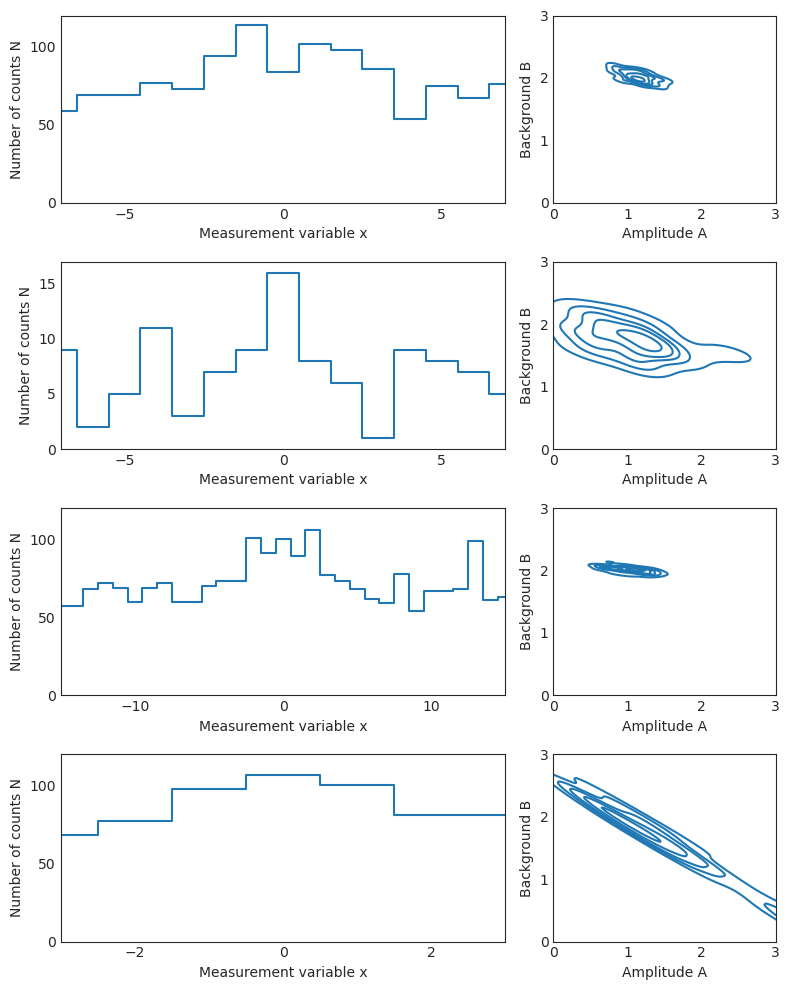

In [20]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(8, 10), gridspec_kw={'width_ratios': [2, 1]})

### First histogram ###
ax1.step(x=plot1_data.bin, y=plot1_data.value, where='mid')

ax1.set_xlim((-7, 7))
ax1.set_ylim(0, 120)
ax1.set_xticks([-5, 0, 5])
ax1.set_yticks([0, 50, 100])

ax1.tick_params(direction='in', length=1)
ax1.set_xlabel('Measurement variable x')
ax1.set_ylabel('Number of counts N')

### First contour plot ###
sns.kdeplot(x=results_1['signal'].ravel(), 
            y=results_1['noise'].ravel(),
            n_levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            ax=ax2)

ax2.set_xlim((0, 3))
ax2.set_ylim((0, 3))
ax2.set_xticks(np.arange(0, 3.1, 1))
ax2.set_yticks(np.arange(0, 3.1, 1))

ax2.tick_params(direction='in', length=1)
ax2.set_xlabel('Amplitude A')
ax2.set_ylabel('Background B')

### Second histogram ###
ax3.step(x=plot2_data.bin, y=plot2_data.value, where='mid')

ax3.set_xlim((-7, 7))
ax3.set_ylim(0, 17)
ax3.set_xticks([-5, 0, 5])
ax3.set_yticks([0, 5, 10, 15])

ax3.tick_params(direction='in', length=1)
ax3.set_xlabel('Measurement variable x')
ax3.set_ylabel('Number of counts N')

### Second contour plot ###
sns.kdeplot(x=results_2['signal'].ravel(), 
            y=results_2['noise'].ravel(),
            n_levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            ax=ax4)

ax4.set_xlim((0, 3))
ax4.set_ylim((0, 3))
ax4.set_xticks(np.arange(0, 3.1, 1))
ax4.set_yticks(np.arange(0, 3.1, 1))

ax4.tick_params(direction='in', length=1)
ax4.set_xlabel('Amplitude A')
ax4.set_ylabel('Background B')


### Third histogram ###
ax5.step(x=plot3_data.bin, y=plot3_data.value, where='mid')

ax5.set_xlim((-15, 15))
ax5.set_ylim(0, 120)
ax5.set_xticks([-10, 0, 10])
ax5.set_yticks([0, 50, 100])

ax5.tick_params(direction='in', length=1)
ax5.set_xlabel('Measurement variable x')
ax5.set_ylabel('Number of counts N')

### Third contour plot ###
sns.kdeplot(x=results_3['signal'].ravel(), 
            y=results_3['noise'].ravel(),
            n_levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            ax=ax6)

ax6.set_xlim((0, 3))
ax6.set_ylim((0, 3))
ax6.set_xticks(np.arange(0, 3.1, 1))
ax6.set_yticks(np.arange(0, 3.1, 1))

ax6.tick_params(direction='in', length=1)
ax6.set_xlabel('Amplitude A')
ax6.set_ylabel('Background B')


### Fourth histogram ###
ax7.step(x=plot4_data.bin, y=plot4_data.value, where='mid')

ax7.set_xlim((-3, 3))
ax7.set_ylim(0, 120)
ax7.set_xticks([-2, 0, 2])
ax7.set_yticks([0, 50, 100])

ax7.tick_params(direction='in', length=1)
ax7.set_xlabel('Measurement variable x')
ax7.set_ylabel('Number of counts N')

### Fourth contour plot ###
sns.kdeplot(x=results_4['signal'].ravel(), 
            y=results_4['noise'].ravel(),
            n_levels=[0.1, 0.3, 0.5, 0.7, 0.9],
            ax=ax8)

ax8.set_xlim((0, 3))
ax8.set_ylim((0, 3))
ax8.set_xticks(np.arange(0, 3.1, 1))
ax8.set_yticks(np.arange(0, 3.1, 1))

ax8.tick_params(direction='in', length=1)
ax8.set_xlabel('Amplitude A')
ax8.set_ylabel('Background B')


plt.tight_layout()
plt.show()

#### Conclusion:
The top panels make out the reference case with an estimated amplitude of A being roughly 1 and that of B being roughly 2. In the second set of panels only 1/10th of the data is provided, correspondingly the posterior pdf is much broader. In the third set of panels we have data spread out over twice the range. This setup makes us more certain about the amplitude of the noise (since we get more measurements that are essentially only noise) but does not much affect our certainty about the amplitude of the peak. In the fourth set of panels there are only 7 measurements, over half the original range. It becomes very hard to separate out the noise from the peak and our estimates of A and B are therefore highly correlated.

# 4 Model selection

## 4.2 Example 6: how many lines are there? (page 85)


<img align="left" src="images/figure_4.2.png" width="550"/> <br clear="all" /><br clear="all" />
Figure 4.2, page 86.

The datapoints as from figure 4.2 on page 86 were extracted from the book figure using WebPlotDigitizer https://automeris.io/WebPlotDigitizer/) and saved to `./data/ex6_model_plot1.tsv`.

In [21]:
df = pd.read_csv('./data/ex6_figure_4_2_data.tsv', sep=',')

In [22]:
def model(x, y, stdev, peaks, fwhm=None):
    """
    n0 is a constant indicating the time measured (not given in book, I just make a rough estimate here).
    """
    x_min_val = x.min().item()
    x_max_val = x.max().item()
    
    y_min_val = y.min().item()
    y_max_val = y.max().item()
    
    # set priors for mu, sigma, and peak size
    mu = pyro.sample('mu', dist.Normal(torch.tensor(np.random.choice(np.arange(x_min_val, x_max_val, (x_max_val-x_min_val)/20), 
                                             size=peaks,
                                             replace=False)), 
                                        torch.ones(peaks)*(x_max_val-x_min_val)/10).independent(1))
    
#     sigma = pyro.sample('sigma', dist.Normal(torch.ones(peaks), 
#                                              torch.ones(peaks)).independent(1))
    
    # I really just want to do HalfNormal here, but it is not available
    sigma = pyro.sample('sigma', dist.TransformedDistribution(
                                dist.FoldedDistribution(dist.Normal(loc=torch.ones(peaks), scale=torch.ones(peaks))),
                                dist.transforms.AffineTransform(loc=0.0, scale=1.0))).double()
    
    amplitude = pyro.sample('amplitude', dist.Normal(torch.ones(peaks)*y_min_val, 
                                                      torch.ones(peaks)*y_max_val).independent(1))

    
    # define the gaussian and find probability value of peak so I can scale to one later
    if fwhm is None:
        gaussian = dist.Normal(mu, sigma)
    else:
        gaussian = dist.Normal(mu, torch.ones(peaks)*fwhm/2.3548) #devide fwhm by 2.3548 to get sigma from fwhm

    
    # get the probability at the peak
    max_prob = gaussian.log_prob( mu.detach() ).exp()
    
    # estimate parameters for linear noise
    beta0 = pyro.sample('beta0', dist.Cauchy(y_min_val, 10))
    beta1 = pyro.sample('beta1', dist.Cauchy(0, 10))
    
    with pyro.plate('observed_data'):
        
        # calculate the probabilites at x
        probs =  gaussian.log_prob( x ).exp()
        signal = amplitude * (probs / max_prob)
        signal = signal.sum(axis=1)
        
        # get the linear noise contribution
        linear_noise = (beta0 + x * beta1).view(-1)
        
        pyro.sample('obs', dist.Normal(signal + linear_noise, stdev), obs=y)


def guide(x, y, stdev, peaks, fwhm=None):
    x_min_val = x.min().item()
    x_max_val = x.max().item()
    
    y_min_val = y.min().item()
    y_max_val = y.max().item()
    
    # the mu paramter
    mu_mu = torch.tensor(np.random.choice(np.arange(x_min_val, x_max_val, (x_max_val-x_min_val)/20), 
                             size=peaks,
                             replace=False))
    mu_mu_param = pyro.param("mu_mu", mu_mu,
                                constraint=dist.constraints.interval(x_min_val, 
                                                                     x_max_val))
    
    mu_sigma = torch.ones(peaks)
    mu_sigma_param = pyro.param("mu_sigma", mu_sigma, 
                                constraint=dist.constraints.positive)
    
    mu = pyro.sample('mu', dist.Normal(loc=mu_mu_param, 
                                       scale=mu_sigma_param).independent(1))
    
    # the sigma
    sigma_mu = torch.ones(peaks)
    sigma_mu_param = pyro.param('sigma_mu', sigma_mu,
                                constraint=dist.constraints.interval(0, 
                                                                     (x_max_val-x_min_val)/2))
    
    sigma_sigma = torch.ones(peaks)
    sigma_sigma_param = pyro.param('sigma_sigma', sigma_sigma, 
                                constraint=dist.constraints.positive)
    
#     sigma = pyro.sample('sigma', dist.Normal(loc=sigma_mu_param, 
#                                              scale=sigma_sigma_param).independent(1))

    sigma = pyro.sample('sigma', dist.TransformedDistribution(
                                    dist.FoldedDistribution(dist.Normal(loc=sigma_mu, scale=sigma_sigma)),
                                    dist.transforms.AffineTransform(loc=0.0, scale=1.0))).double()
    
    
    # the amplitude
    amplitude_mu = torch.tensor(np.random.choice(np.arange(y_min_val, y_max_val, (y_max_val-y_min_val)/20), 
                             size=peaks,
                             replace=False))
    amplitude_mu_param = pyro.param('amplitude_mu', amplitude_mu,
                                 constraint=dist.constraints.interval(y_max_val/100, y_max_val))
        
    amplitude_sigma = torch.ones(peaks)
    amplitude_sigma_param = pyro.param('amplitude_sigma', amplitude_sigma,
                                constraint=dist.constraints.positive)
    
    amplitude = pyro.sample('amplitude', dist.Normal(amplitude_mu_param, amplitude_sigma_param).independent(1))
    
    
    # estimate parameters for linear noise
    beta0_mu = pyro.param('beta0_mu', dist.Uniform(torch.tensor([y_min_val]), 
                                 torch.tensor([y_max_val])),
                                 constraint=dist.constraints.interval(0, y_max_val))
    beta0_sigma = pyro.param('beta0_sigma', torch.tensor([10.0]),
                                 constraint=dist.constraints.positive)
    beta0 = pyro.sample('beta0', dist.Cauchy(beta0_mu, beta0_sigma))
    
    beta1_mu = pyro.param('beta1_mu', torch.tensor([0.0]))
    beta1_sigma = pyro.param('beta1_sigma', torch.tensor([10.0]),
                            constraint=dist.constraints.positive)
    beta1 = pyro.sample('beta1', dist.Cauchy(beta1_mu, beta1_sigma))

In [23]:
def run_peak_model(model, data, num_samples=10):
    results = {}

    # Clear named parameters so that runs don't interfere
    pyro.clear_param_store()

    # Using NUTS here as it seems to perform better than HMC
    my_kernel = NUTS(model)

    # define the MCMC process
    my_mcmc = MCMC(my_kernel,
                   num_samples=num_samples,
                   warmup_steps=40)

    # Only use the first n datapoints
    # to show how belief is updated as we see more and more data
    my_mcmc.run(x=torch.tensor(data.x).view(-1, 1), 
                y=torch.tensor(data.y), 
                stdev=torch.tensor(data.stdev), 
                peaks=2,
                fwhm=None)

    # store results for later plotting
    results['mu'] = my_mcmc.get_samples()['mu'].numpy()
    results['sigma'] = my_mcmc.get_samples()['sigma'].numpy()
    results['amplitude'] = my_mcmc.get_samples()['amplitude'].numpy()
    results['beta0'] = my_mcmc.get_samples()['beta0'].numpy()
    results['beta1'] = my_mcmc.get_samples()['beta1'].numpy()
    
    return results


res = run_peak_model(model, df, num_samples=50)

Sample: 100%|██████████| 90/90 [03:00,  2.00s/it, step size=4.54e-24, acc. prob=0.121]


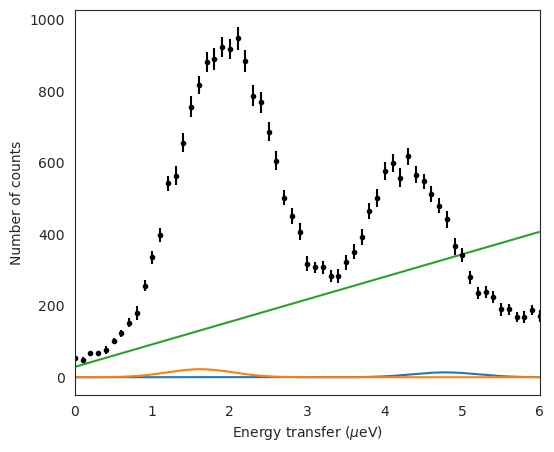

In [24]:
fig = plt.figure(figsize=(6, 5))

ax = fig.add_subplot(1, 1, 1)

x = np.arange(0.0, 6.0, 0.01)

# plot the estimated gaussians
for i in range(res['mu'].shape[1]):
    y = norm.pdf(x, loc=res['mu'].mean(axis=0)[i], 
                    scale=1.0/2.3548) * res['amplitude'].mean(axis=0)[i]
    plt.plot(x, y)

# plot the linear model
y = res['beta0'].mean(axis=0) + res['beta1'].mean(axis=0) * x
plt.plot(x, y)
    
# add the data points
plt.errorbar(df.x, df.y, yerr=df.stdev, c='black', fmt='o', markersize=3)
plt.xlabel('Energy transfer ($\mu$eV)')
plt.ylabel('Number of counts')

plt.xlim((0, 6))

plt.show()

#### Conclusion:
This works pretty nicely, but the analysis is very sensitive to the chosen sigma of the normal distribution. With smaller values (which give peaks more similar to the plot in the book) the estimated mu values are not correct. For example, sometimes I get two distributions in the second data peak. 

### x

<img align="left" src="images/figure_4.3.png" width="550"/> <br clear="all" /><br clear="all" />
Figure 4.3, page 92.

The datapoints as from figure 4.3 on page 92 were extracted from the book figure using WebPlotDigitizer https://automeris.io/WebPlotDigitizer/) and saved to `./data/ex6_model_plot1.tsv`.

In [25]:
df = pd.read_csv('./data/ex6_figure_4_3_data.tsv', sep=',')

In [26]:
res = run_peak_model(model, df, num_samples=100)

Sample: 100%|██████████| 140/140 [04:14,  1.82s/it, step size=8.93e-30, acc. prob=0.004]


In [27]:
res

{'mu': array([[ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, -1.60288687],
        [ 0.08747375, 

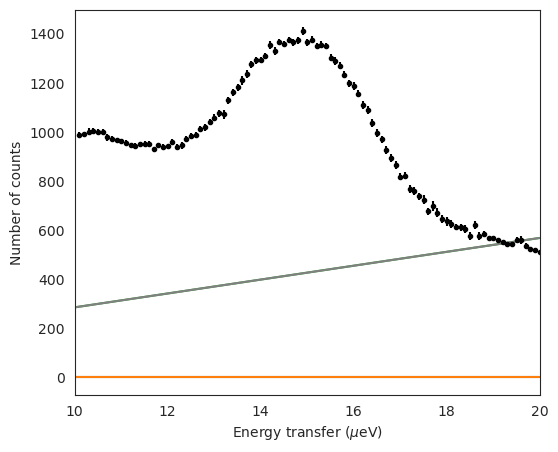

In [28]:
fig = plt.figure(figsize=(6, 5))

ax = fig.add_subplot(1, 1, 1)

x = np.arange(10.0, 20.0, 0.01)

all_y = x * 0

# plot the estimated gaussians
for i in range(res['mu'].shape[1]):
    y = norm.pdf(x, loc=res['mu'].mean(axis=0)[i], 
                    scale=3.0/2.3548) * res['amplitude'].mean(axis=0)[i]
    plt.plot(x, y)
    
    all_y += np.array(y)

# plot the linear model
y = res['beta0'].mean(axis=0) + res['beta1'].mean(axis=0) * x
plt.plot(x, y)

all_y += np.array(y)

# plot the sum of y
plt.plot(x, all_y, c='grey')
    
# add the data points
plt.errorbar(df.x, df.y, yerr=df.stdev, c='black', fmt='o', markersize=3)

plt.xlabel('Energy transfer ($\mu$eV)')
plt.ylabel('Number of counts')

plt.xlim((10, 20))

plt.show()

In [29]:
# Clear all the parameter store
pyro.clear_param_store()

# Define the SVI algorithm.
my_svi = SVI(model=model,
             guide=guide,
             optim=ClippedAdam({"lr": 0.1}),
             loss=Trace_ELBO())

param_vals = []
optimization_steps = 5000
for i in range(optimization_steps):

    loss = my_svi.step(x=torch.tensor(df.x).view(-1, 1), 
                       y=torch.tensor(df.y), 
                       stdev=torch.tensor(df.stdev), 
                       peaks=2,
                       fwhm=2)

    # store values for inspection later
    param_vals.append({k: param(k).detach().numpy() for k in ['mu_mu', 'mu_sigma',
                                             'sigma_mu', 'sigma_sigma', 
                                             'amplitude_mu', 'amplitude_sigma',
                                             'beta0_mu', 'beta0_sigma',
                                             'beta1_mu', 'beta1_sigma']})
    param_vals[-1]['loss'] = loss

    if (i % 100 == 0):
        print(f'iter: {i}, loss: {round(loss, 2)}', end='\r')


In [30]:
param_vals[-1]

{'mu_mu': array([10.1       , 14.80806091]),
 'mu_sigma': array([0.6448453 , 0.01032303], dtype=float32),
 'sigma_mu': array([1., 1.], dtype=float32),
 'sigma_sigma': array([1., 1.], dtype=float32),
 'amplitude_mu': array([ 47.91785892, 716.07658025]),
 'amplitude_sigma': array([3.7495732, 2.528924 ], dtype=float32),
 'beta0_mu': array([1411.1991], dtype=float32),
 'beta0_sigma': array([0.43468094], dtype=float32),
 'beta1_mu': array([-43.20635], dtype=float32),
 'beta1_sigma': array([0.01406727], dtype=float32),
 'loss': 2641.84543309426}

**Plot the results**

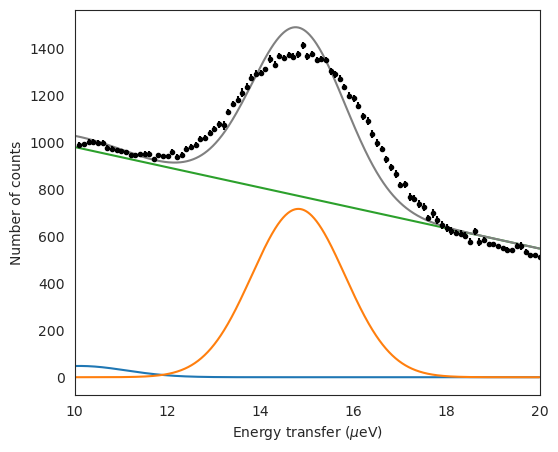

In [31]:
fig = plt.figure(figsize=(6, 5))

ax = fig.add_subplot(1, 1, 1)

x = np.arange(10.0, 20.0, 0.01)

all_y = x * 0

# plot the estimated gaussians
for i in range(param_vals[-1]['mu_mu'].shape[0]):
    mu = param_vals[-1]['mu_mu'][i]
    sigma = param_vals[-1]['sigma_mu'][i]
    amplitude = param_vals[-1]['amplitude_mu'][i]
    max_prob = dist.Normal(mu, sigma).log_prob(mu).exp()
    
    y = dist.Normal(loc=mu, scale=sigma).log_prob( torch.tensor(x) ).exp() * amplitude/max_prob
    plt.plot(x, y)
    
    all_y += np.array(y)

# plot the linear model
y = param_vals[-1]['beta0_mu'] + param_vals[-1]['beta1_mu'] * x
plt.plot(x, y)

all_y += np.array(y)

# plot the sum of y
plt.plot(x, all_y, c='grey')
    
# add the data points
plt.errorbar(df.x, df.y, yerr=df.stdev, c='black', fmt='o', markersize=3)

plt.xlabel('Energy transfer ($\mu$eV)')
plt.ylabel('Number of counts')

plt.xlim((10, 20))

plt.show()